# Obesity Classification and Predictions
## Team: 
- Amr Alaa
- Ali Adel
- Adham Assy
- Israa Abdelghany
---

# `1` Importing libraries and Loading Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from utils import plot_numerical_pies, categorical_analysis, plot_categorical_data, plot_numerical_data, map_data

In [2]:
dataset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (16606, 18), Test shape: (4152, 18)


# `2` Exploratory Data Analysis

In [29]:
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
9958,9958,Male,17.000000,1.770000,97.000000,yes,yes,3.0,3.000000,Always,no,2.000000,no,3.000000,1.0,no,Automobile,Obesity_Type_I
7841,7841,Male,22.667596,1.753389,54.877111,yes,yes,2.0,4.000000,Sometimes,no,2.000000,no,2.000000,1.0,no,Public_Transportation,Insufficient_Weight
9293,9293,Male,21.838323,1.819867,122.024954,yes,yes,3.0,2.880817,Sometimes,no,1.645338,no,0.739881,0.0,Sometimes,Public_Transportation,Obesity_Type_II
15209,15209,Female,41.000000,1.580000,80.000000,yes,yes,2.0,3.000000,Sometimes,no,1.000000,no,0.000000,0.0,Sometimes,Automobile,Obesity_Type_I
16515,16515,Male,23.000000,1.800000,95.000000,yes,no,3.0,3.000000,Sometimes,no,3.000000,no,2.000000,1.0,Frequently,Public_Transportation,Overweight_Level_II


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16606 entries, 9958 to 15795
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              16606 non-null  int64  
 1   Gender                          16606 non-null  object 
 2   Age                             16606 non-null  float64
 3   Height                          16606 non-null  float64
 4   Weight                          16606 non-null  float64
 5   family_history_with_overweight  16606 non-null  object 
 6   FAVC                            16606 non-null  object 
 7   FCVC                            16606 non-null  float64
 8   NCP                             16606 non-null  float64
 9   CAEC                            16606 non-null  object 
 10  SMOKE                           16606 non-null  object 
 11  CH2O                            16606 non-null  float64
 12  SCC                             16

**No missing values**

## Categorical Data Analysis

In [5]:
attribute_meanings = {
    'FAVC':'Frequent consumption of high caloric food',
    'FCVC': 'Frequency of consumption of vegetables',
    'NCP': 'Number of main meals',
    'CAEC': 'Consumption of food between meals',
    'CH20': 'Consumption of water daily',
    'CALC': 'Consumption of alcohol', 
    'SCC': 'Calories consumption monitoring',
    'FAF': 'Physical activity frequency',
    'TUE': 'Time using technology devices',
    'MTRANS': 'Transportation used'
}

In [6]:
for col in train.columns:
    if train[col].dtype == 'object':
        unique_values = train[col].unique()
        if col in attribute_meanings:
            print(f"Column: {attribute_meanings[col]} ({col})")
        else:
            print(f"Column: {col}")
        print(f"Unique values: {', '.join(unique_values)}\n")

Column: Gender
Unique values: Male, Female

Column: family_history_with_overweight
Unique values: yes, no

Column: Frequent consumption of high caloric food (FAVC)
Unique values: yes, no

Column: Consumption of food between meals (CAEC)
Unique values: Always, Sometimes, no, Frequently

Column: SMOKE
Unique values: no, yes

Column: Calories consumption monitoring (SCC)
Unique values: no, yes

Column: Consumption of alcohol (CALC)
Unique values: no, Sometimes, Frequently

Column: Transportation used (MTRANS)
Unique values: Automobile, Public_Transportation, Walking, Motorbike, Bike

Column: NObeyesdad
Unique values: Obesity_Type_I, Insufficient_Weight, Obesity_Type_II, Overweight_Level_II, Normal_Weight, Obesity_Type_III, Overweight_Level_I



In [7]:
gender_mapping = {'Male': 0, 'Female': 1}
yes_no_mapping = {'no': 0, 'yes': 1}
freq_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
transportion_mapping = {'Walking': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Automobile': 4}
target_mapping = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
mapping_dict = {
    'Gender' : gender_mapping,
    'family_history_with_overweight' : yes_no_mapping,
    'FAVC' : yes_no_mapping,
    'CAEC': freq_mapping,
    'SMOKE': yes_no_mapping,
    'SCC': yes_no_mapping,
    'CALC': freq_mapping,
    'MTRANS': transportion_mapping,
    'NObeyesdad': target_mapping
}

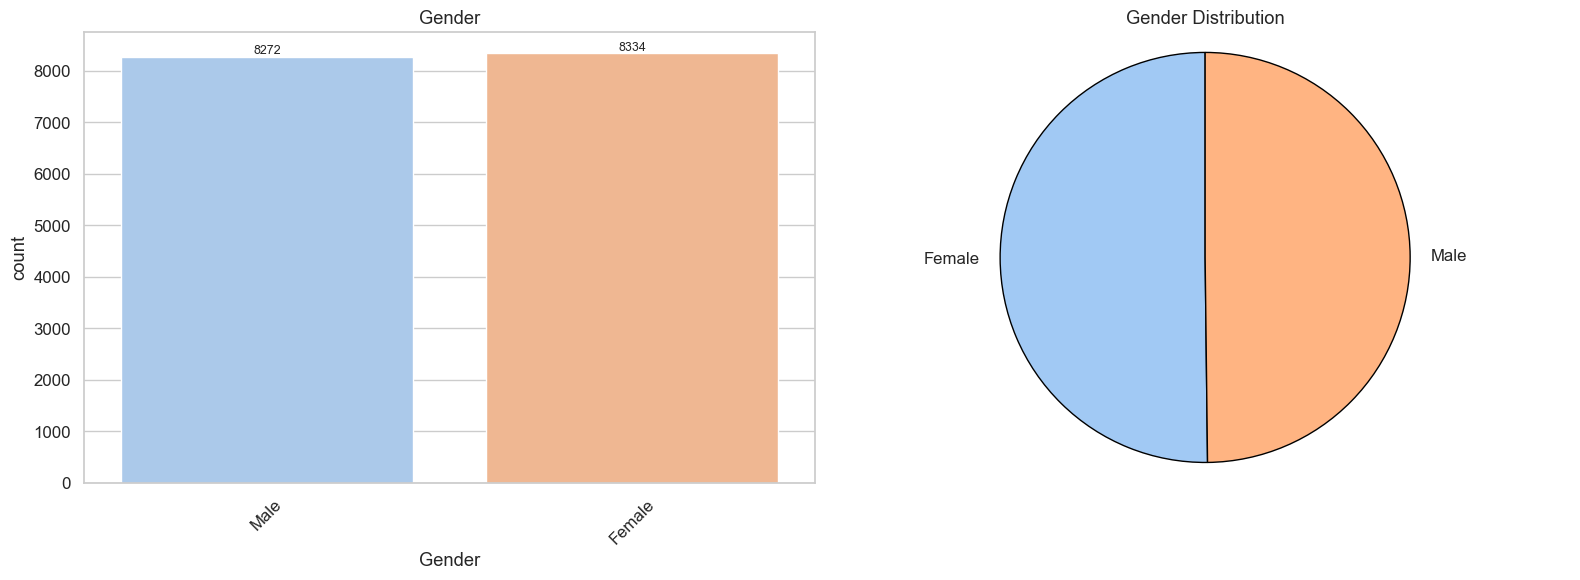

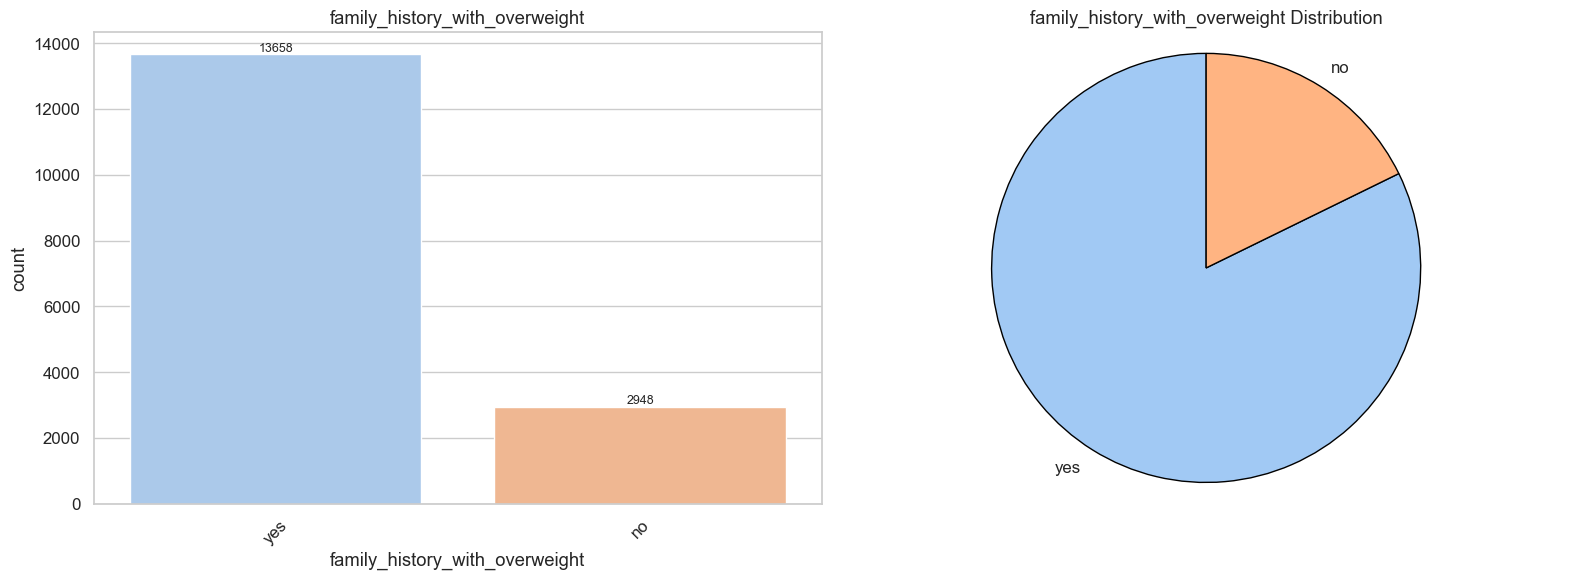

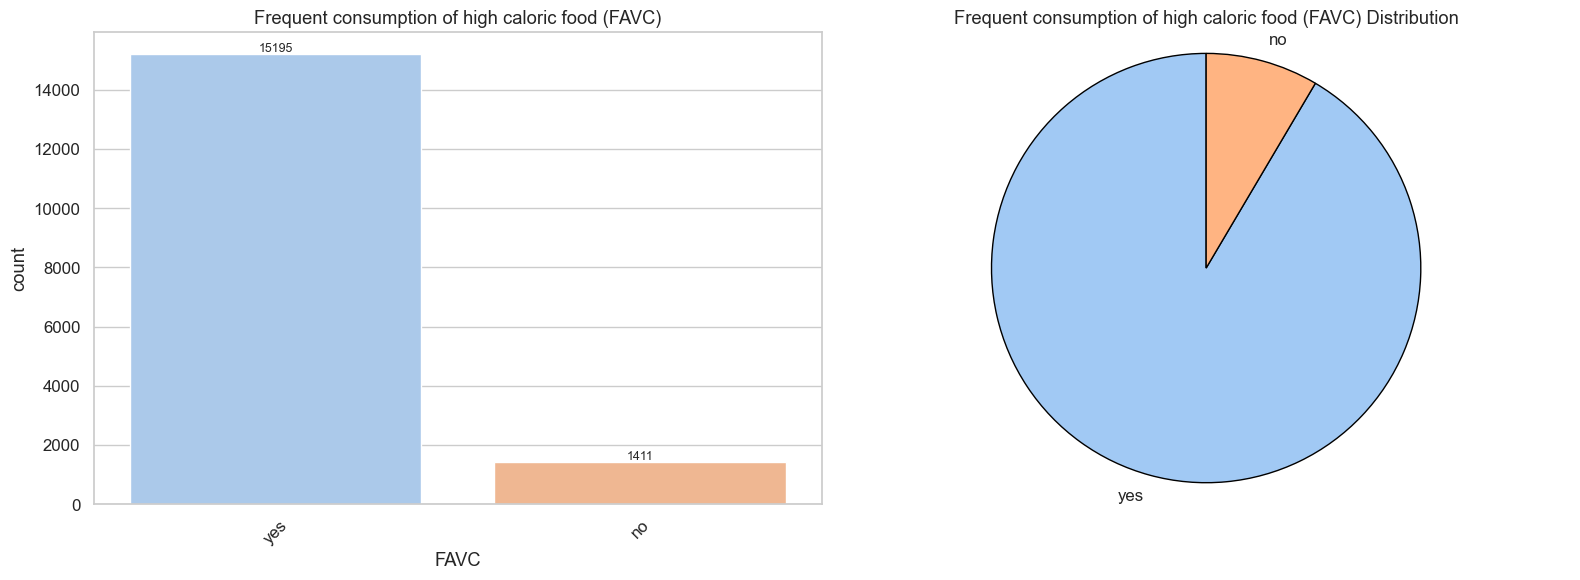

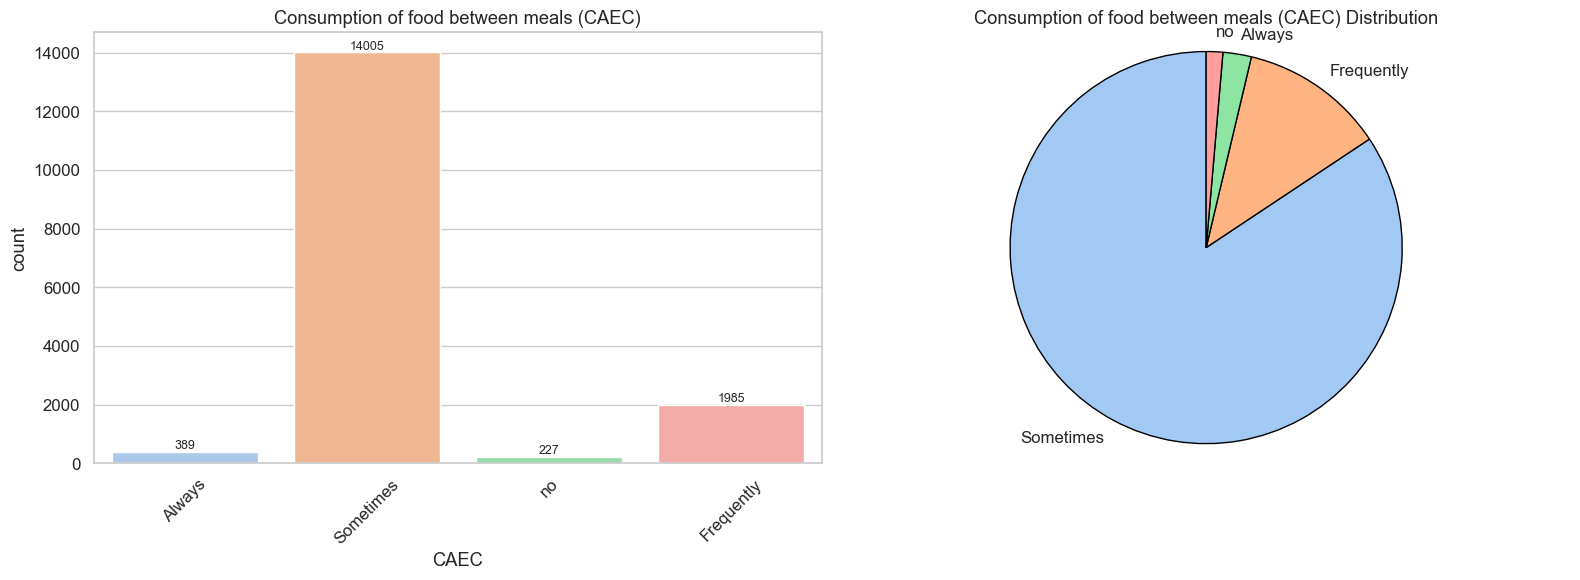

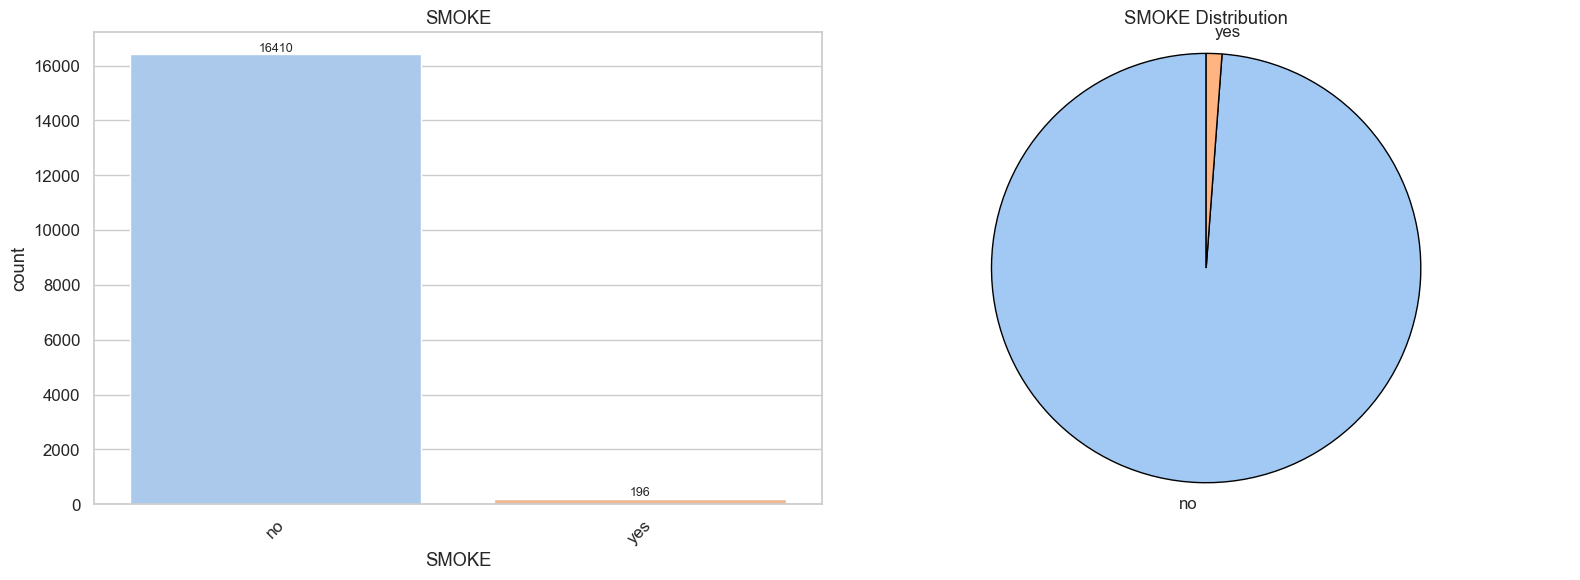

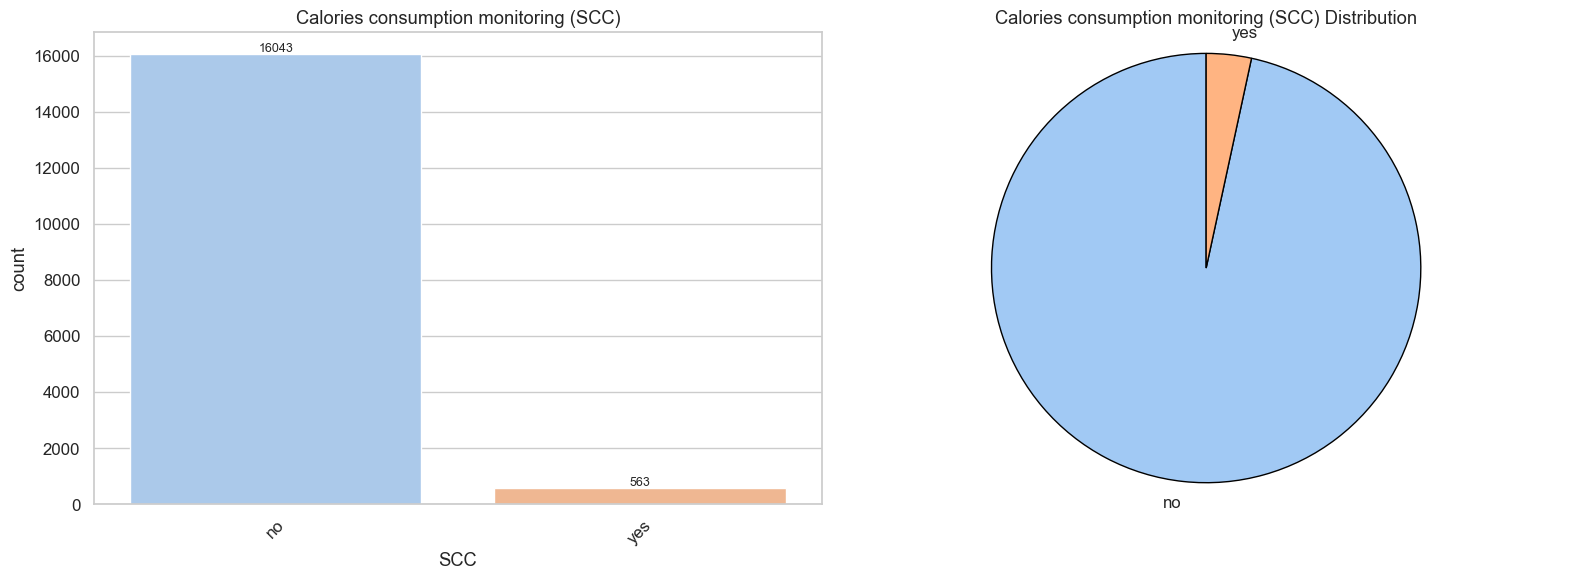

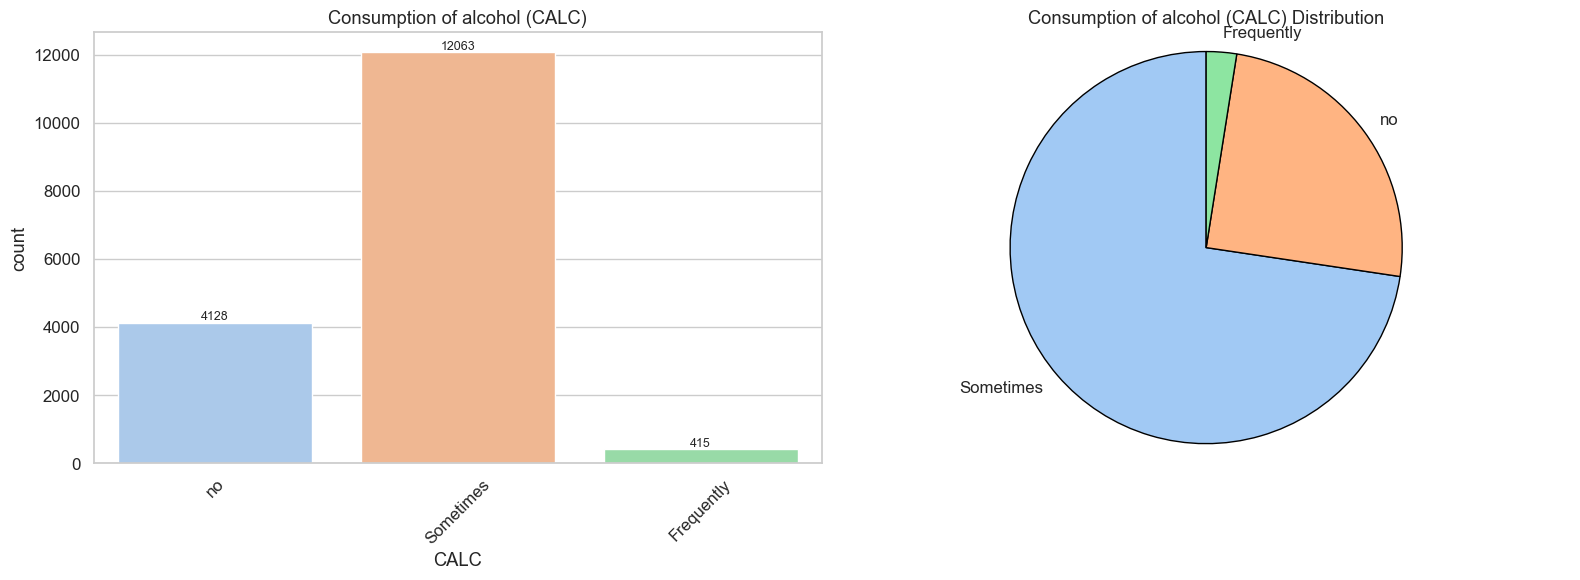

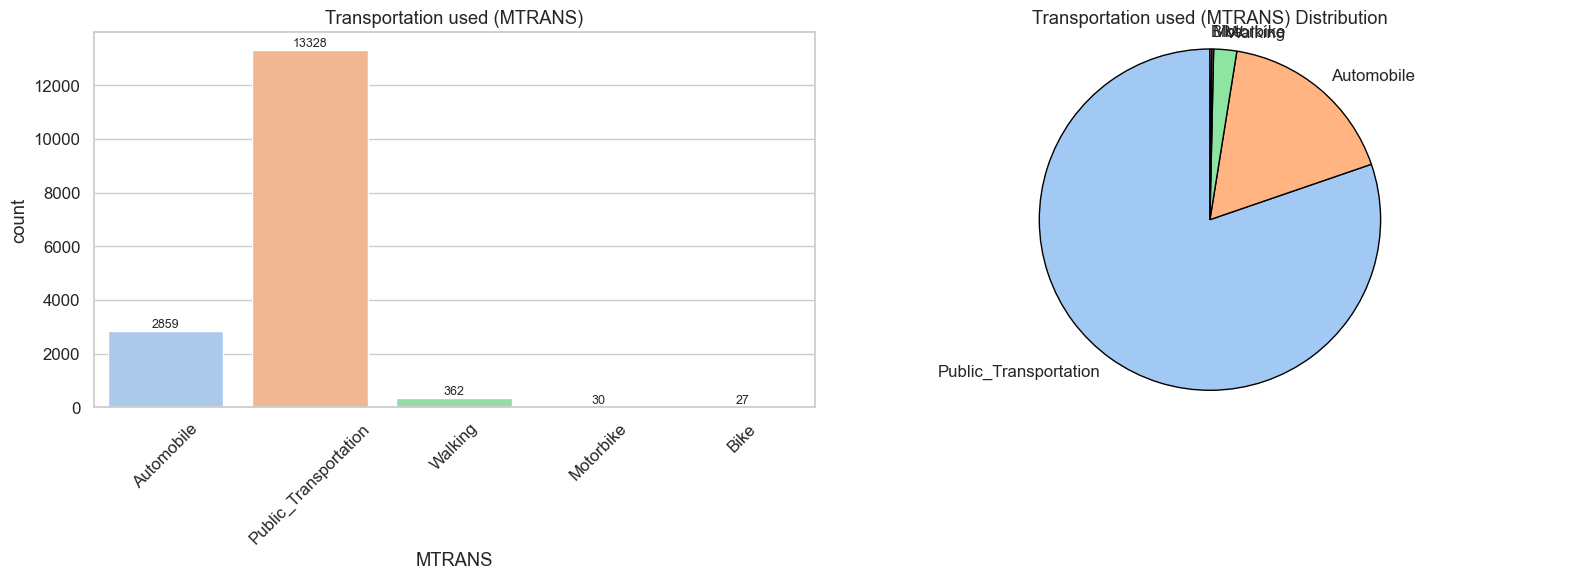

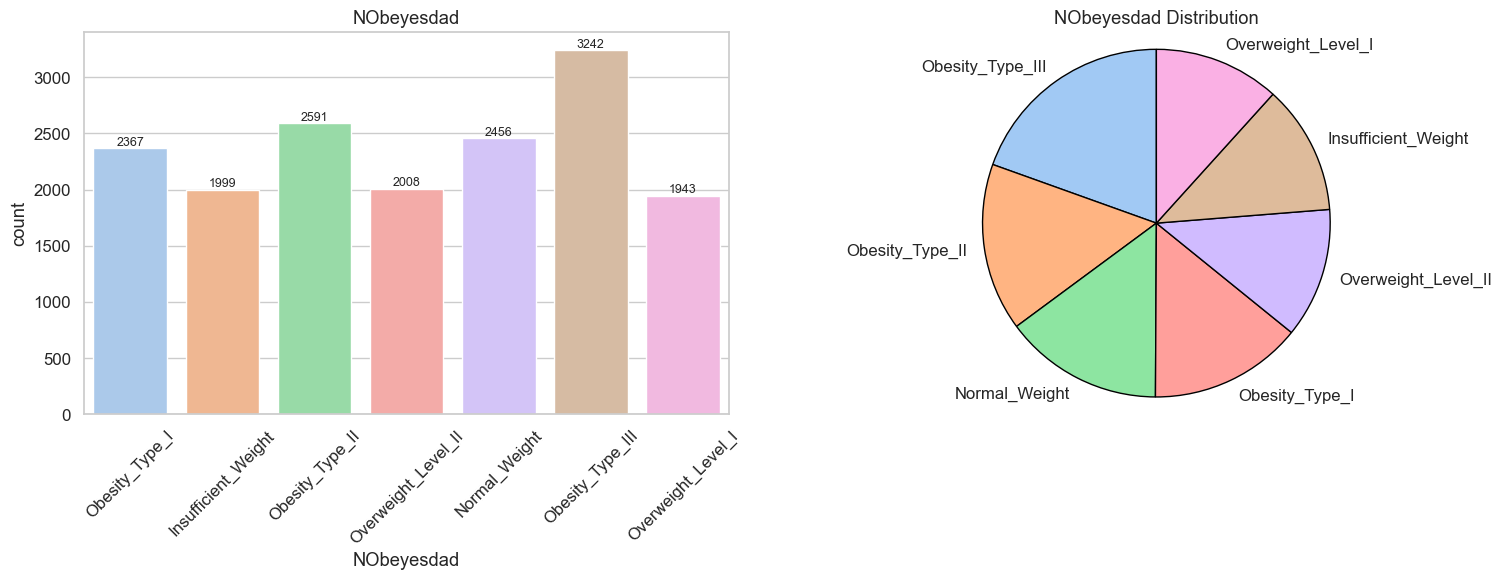

In [99]:
for col in train.columns:
    if train[col].dtype == 'object':
        counts = train[col].value_counts()
        labels = counts.index
        sizes = counts.values

        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        if col in attribute_meanings:
            title = f"{attribute_meanings[col]} ({col})"
        else:
            title = f"{col}"

        sns.countplot(data=train, x=col, hue=col, ax=axs[0], palette='pastel')
        axs[0].set_title(title)
        axs[0].tick_params(axis='x', rotation=45)

        for p in axs[0].patches:
            height = int(p.get_height())
            axs[0].annotate(str(height), (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', fontsize=9)

        axs[1].pie(
            sizes,
            labels=labels,
            startangle=90,
            colors=sns.color_palette('pastel'),
            wedgeprops={'edgecolor': 'black', 'linewidth': 1}
        )
        axs[1].axis('equal')
        axs[1].set_title(f"{title} Distribution")

        plt.tight_layout()
        plt.savefig(f"EDA/{col}_distribution.png", dpi=300)
        plt.show()



- **Gender Balance**: The dataset is **evenly split between males and females**, ensuring gender-balanced representation.

- **Family History**: A **majority of individuals report a family history of overweight**, indicating a potential hereditary influence in the dataset.

- **High-Calorie Food Consumption**: Most participants **frequently consume high-calorie foods**, which may contribute to higher obesity levels.

- **Snacking Behavior**: A large portion of people **sometimes eat between meals**, highlighting moderate snacking habits in the population.

- **Smoking Habits**: The majority of individuals are **non-smokers**, which may influence other health-related features.

- **Calorie Monitoring**: Most participants **do not actively monitor their calorie intake**, suggesting a lack of structured dietary control.

- **Alcohol Consumption**: **Occasional alcohol consumption** is common among the population, showing moderate drinking behavior.

- **Transportation Habits**: The dominant mode of transport is **public transportation**, which may imply higher levels of incidental physical activity compared to car owners.

- **Weight Class Distribution**: The data is **fairly evenly distributed across the seven obesity categories**, allowing for balanced model training across all target classes.

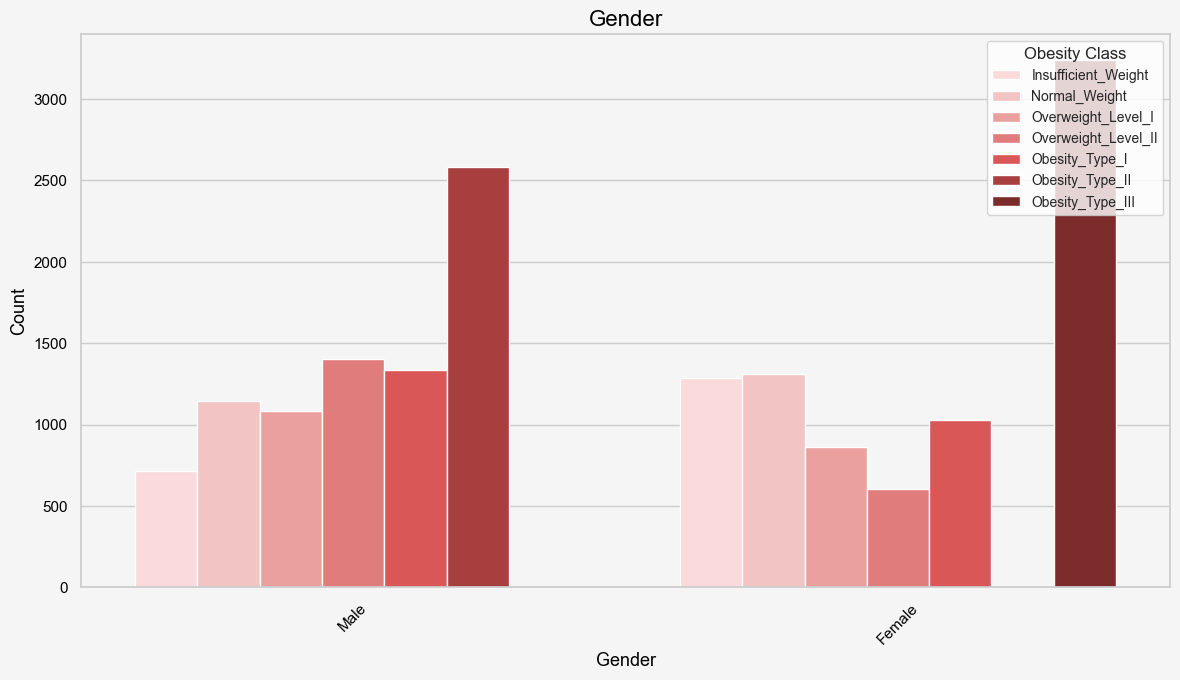

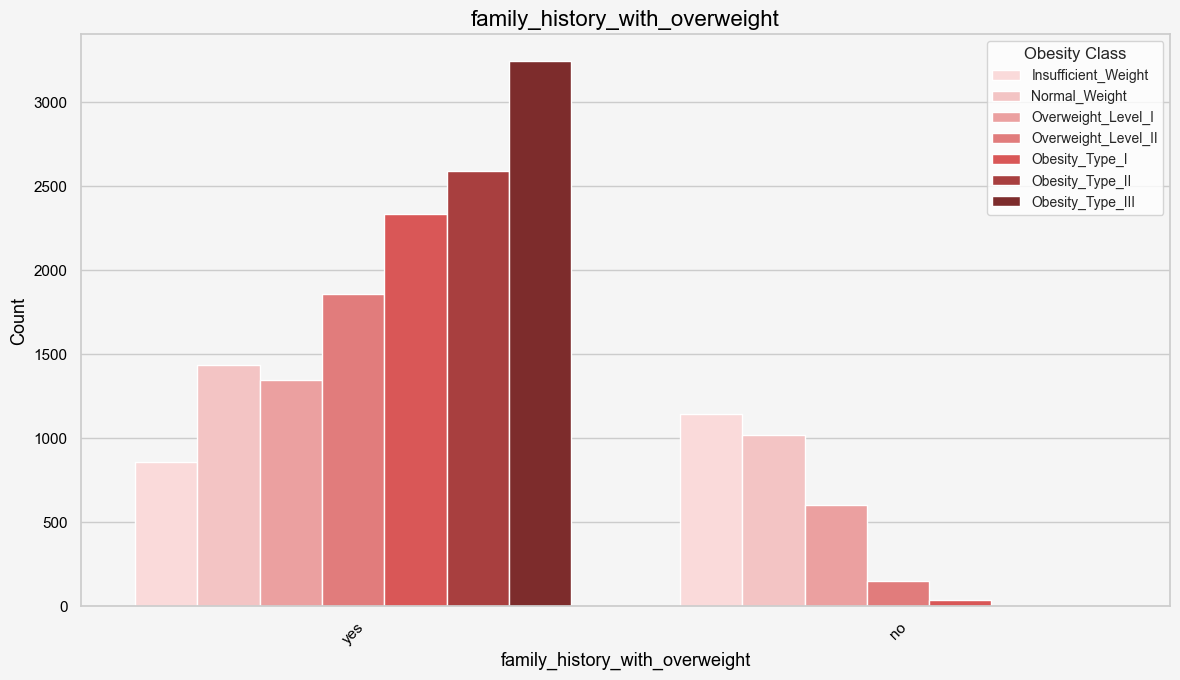

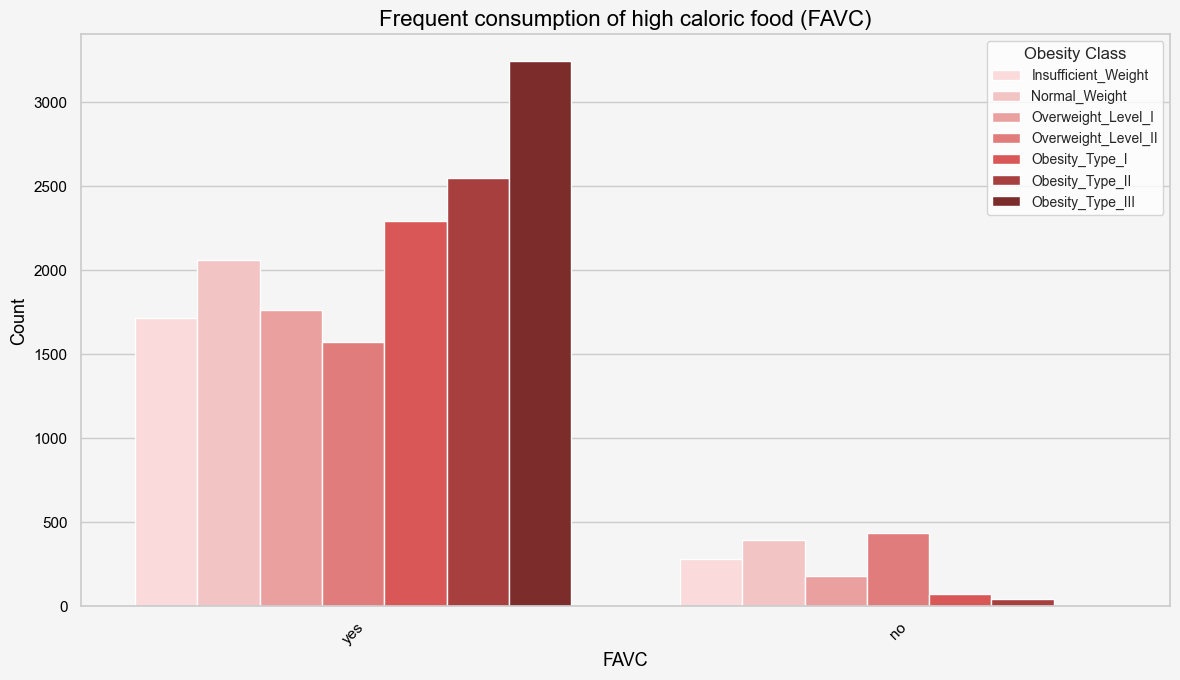

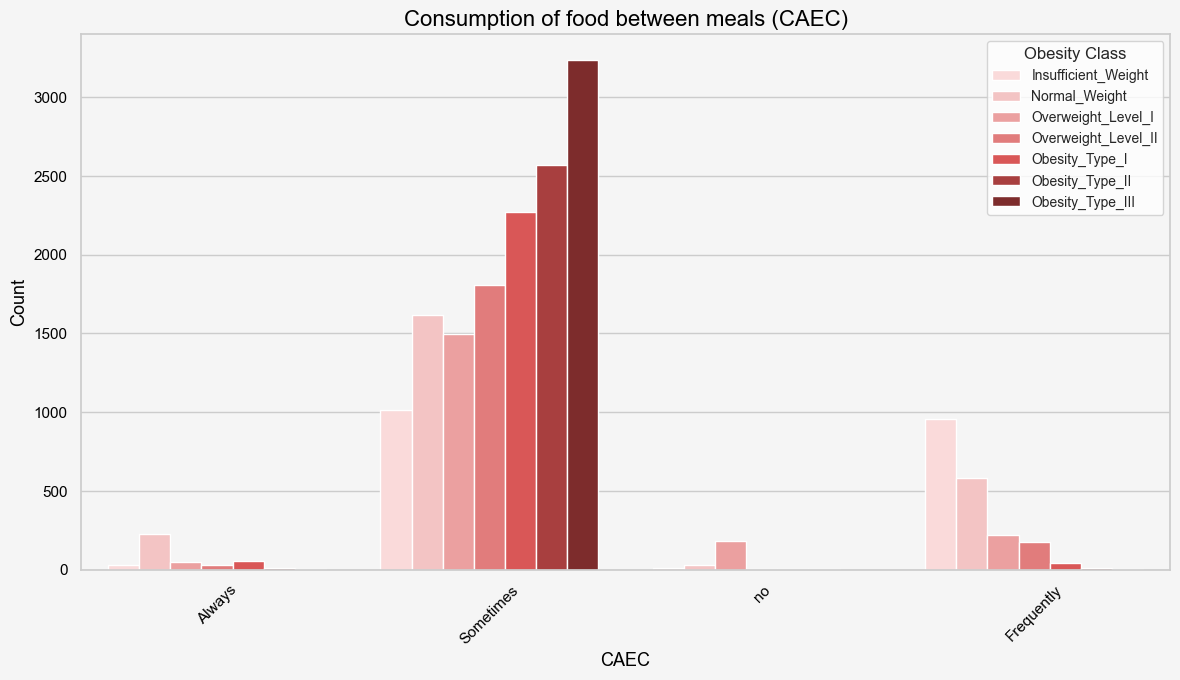

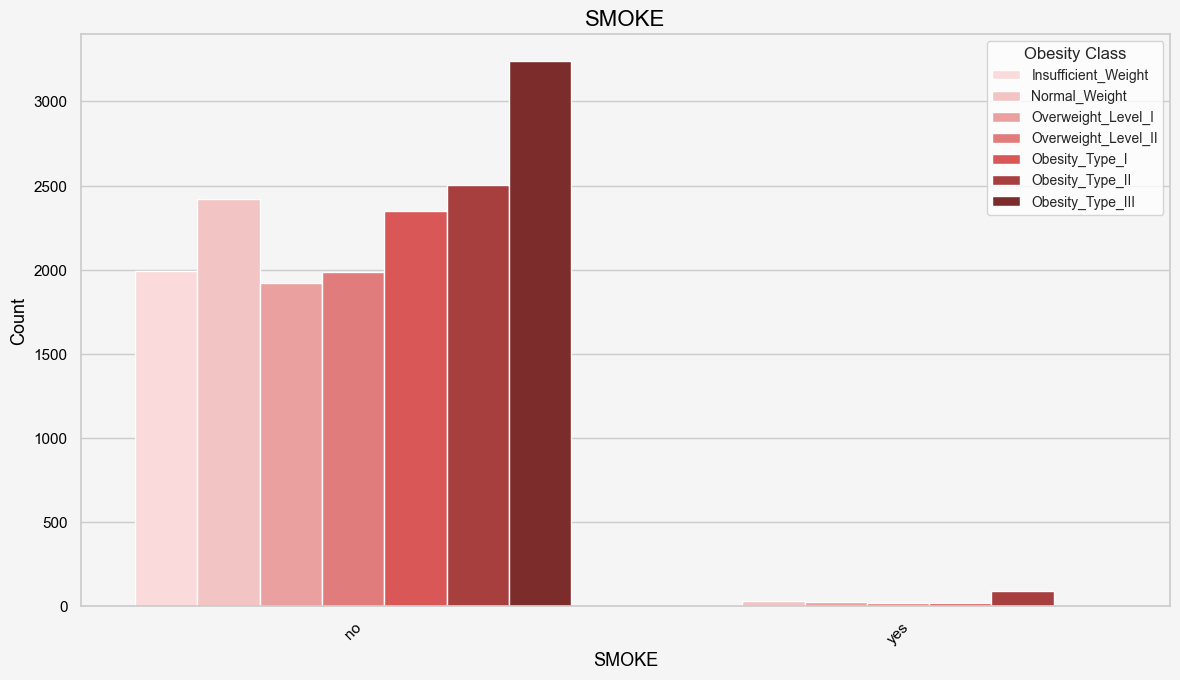

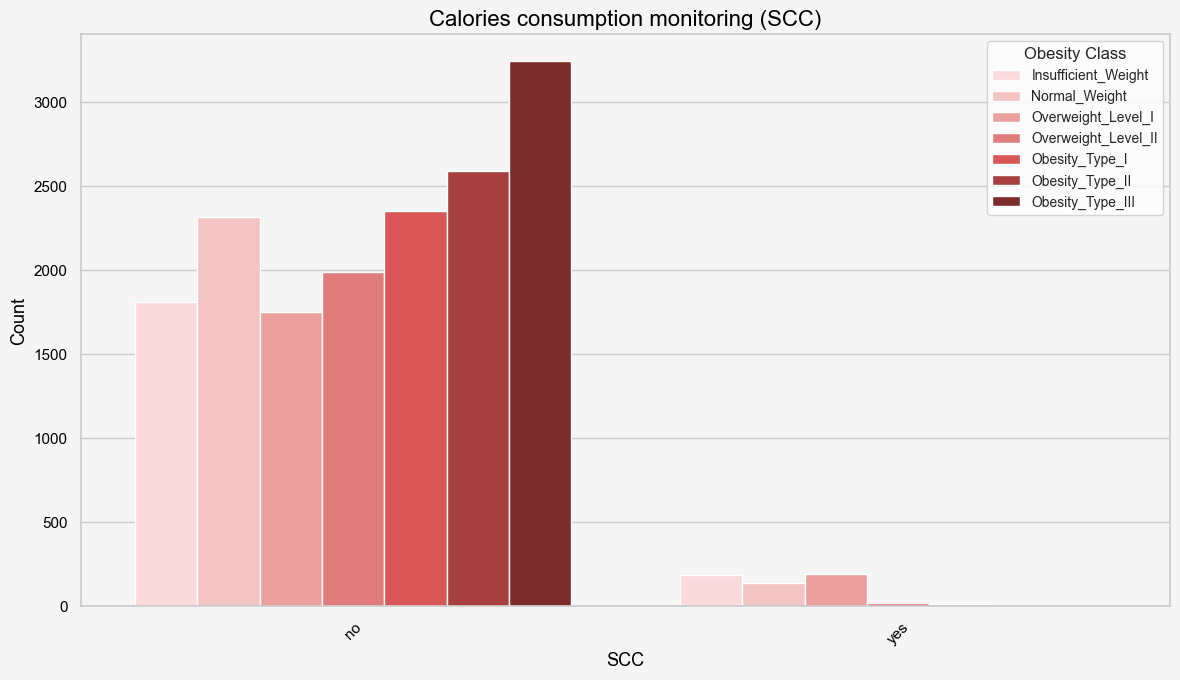

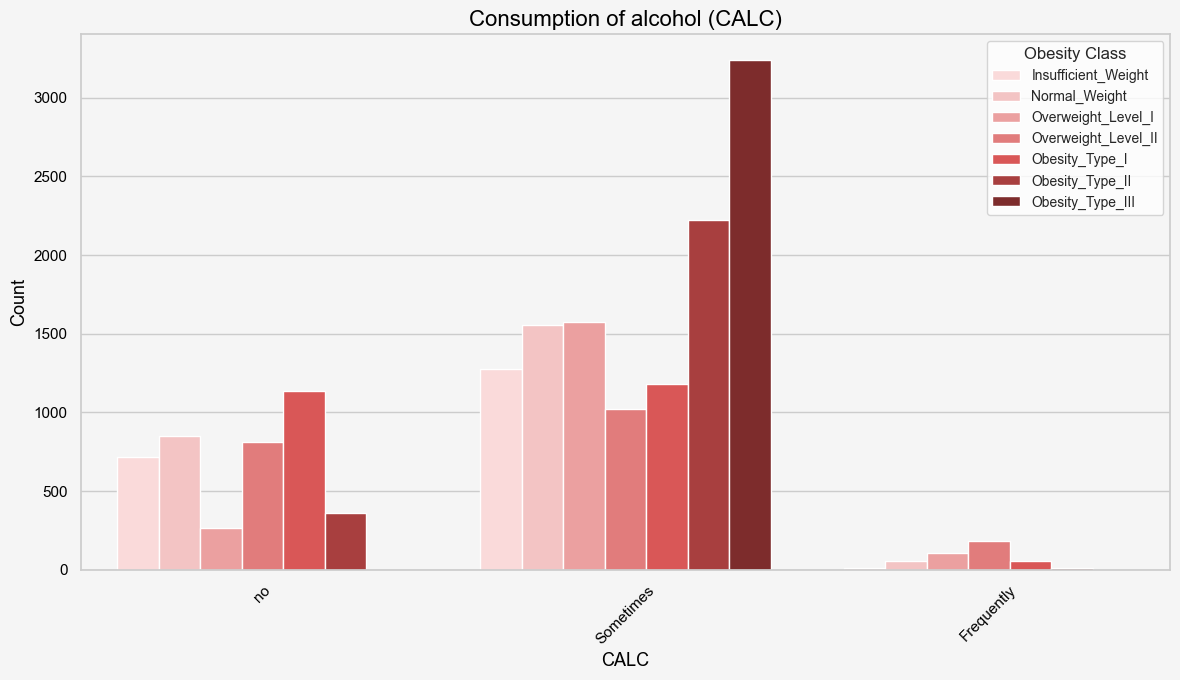

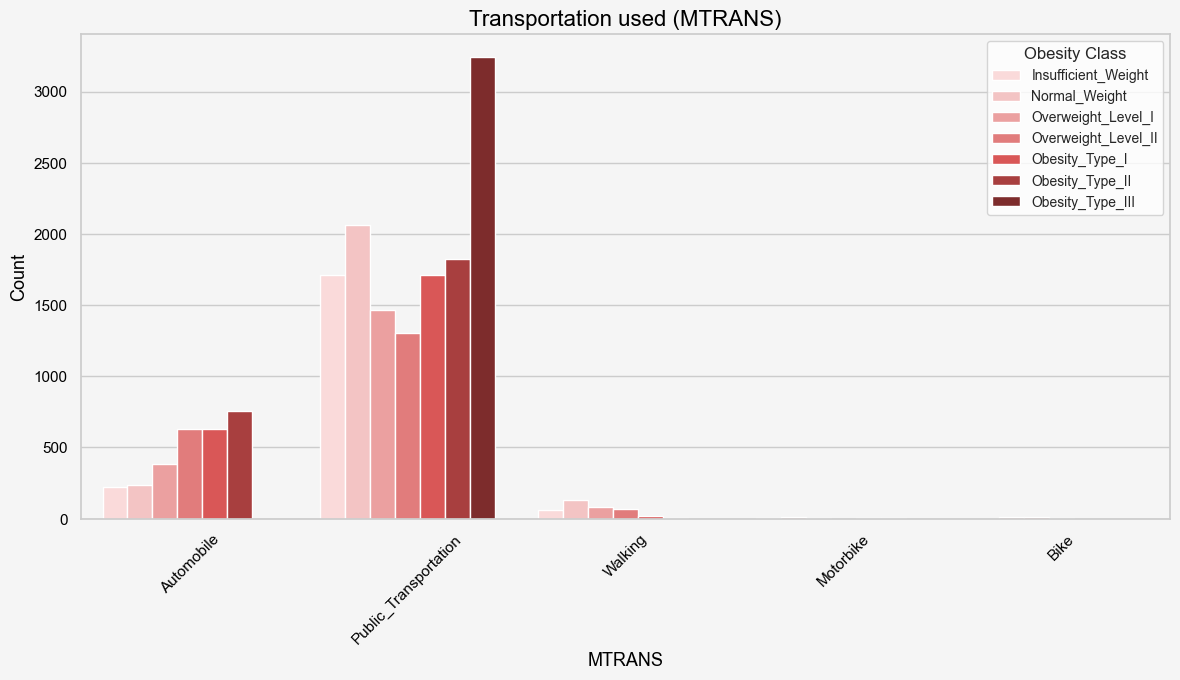

In [100]:
custom_reds = ['#ffd5d5', '#fbbcbc', '#f79494', '#f26b6b', '#ee4242', '#b92e2e', '#8b1e1e']

background_color = '#f5f5f5'

for col in train.columns:
    if train[col].dtype == 'object' and col != 'NObeyesdad':
        plt.figure(figsize=(12, 7))
        ax = plt.gca()

        ax.set_facecolor(background_color)
        plt.gcf().patch.set_facecolor(background_color)

        hue_order = sorted(target_mapping.values())
        hue_labels = {v: k for k, v in target_mapping.items()}
        train['target_label'] = train['NObeyesdad'].map(target_mapping)

        sns.countplot(
            data=train,
            x=col,
            hue='target_label',
            palette=custom_reds,
            hue_order=hue_order,
            ax=ax
        )

        if col in attribute_meanings:
            title = f"{attribute_meanings[col]} ({col})"
        else:
            title = f"{col}"
        ax.set_title(title, fontsize=16, color='black')

        ax.set_xlabel(col, fontsize=13, color='black')
        ax.set_ylabel("Count", fontsize=13, color='black')

        ax.tick_params(axis='x', rotation=45, labelsize=11, colors='black')
        ax.tick_params(axis='y', labelsize=11, colors='black')

        handles, labels = ax.get_legend_handles_labels()
        updated_labels = [hue_labels[int(label)] for label in labels]
        ax.legend(handles, updated_labels, title="Obesity Class", title_fontsize=12, fontsize=10, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(f"EDA/{col}_by_obesity_class.png", dpi=300, facecolor=background_color)
        plt.show()

train.drop(columns='target_label', inplace=True)


- **Gender and Weight Classes**: The distribution of the seven weight classes is **similar across males and females**, with the exception of a **notable absence of the Obesity Type II (class 5)** in females. This could indicate gender-specific behavioral or genetic factors influencing obesity.

- **Family History of Overweight**: There is a **strong correlation** between **family history of overweight** and higher obesity levels. Individuals with a family history of obesity are more likely to belong to higher weight classes, suggesting a genetic or environmental influence on body weight.

- **Eating Habits and Weight Classes**: Several eating habits, including **frequent consumption of high-calorie food (FAVC)**, **eating between meals (CAEC)**, and **calories consumption monitoring (SCC)**, show a strong correlation with higher obesity levels. **Smoking** and **alcohol consumption** are also associated with weight class, indicating lifestyle choices that influence body weight.

- **Transportation and Weight Classes**: **Public transportation use** and **car ownership** appear to correlate with different weight classes. This could point to the relationship between physical activity (often linked to walking or biking for public transport) and lifestyle choices related to transportation.

## Numerical Data Analysis

In [80]:
train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000,16606.000000
mean,10363.210888,23.892845,1.700198,87.956749,2.443641,2.761547,2.028798,0.985767,0.619577
std,5999.344301,5.747219,0.087166,26.325476,0.532843,0.703855,0.607255,0.841048,0.604124
min,0.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5171.250000,20.000000,1.631856,66.401407,2.000000,3.000000,1.796257,0.008822,0.000000
50%,10377.500000,22.832105,1.700000,84.200830,2.369143,3.000000,2.000000,1.000000,0.573958
75%,15542.500000,26.000000,1.762461,111.600553,3.000000,3.000000,2.533263,1.600536,1.000000
max,20757.000000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


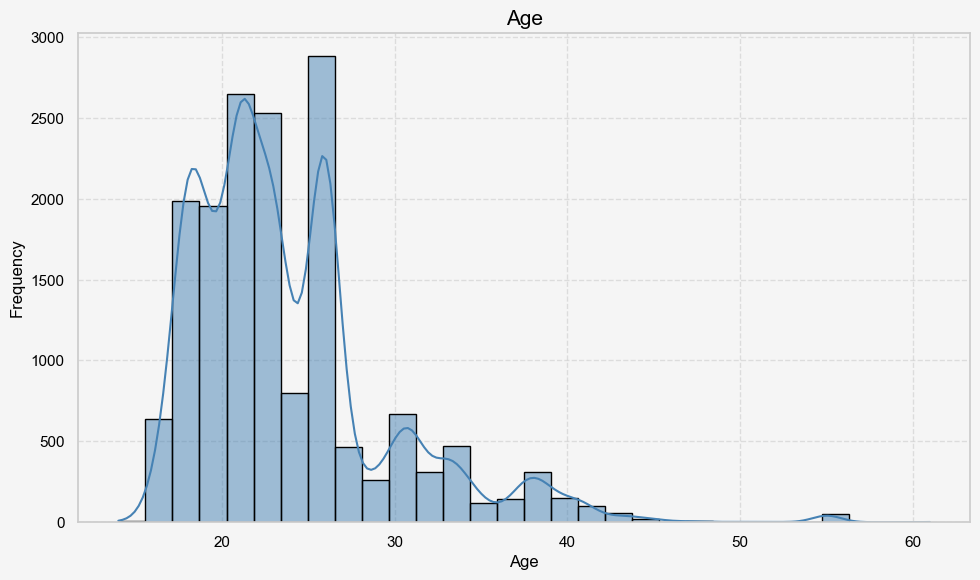

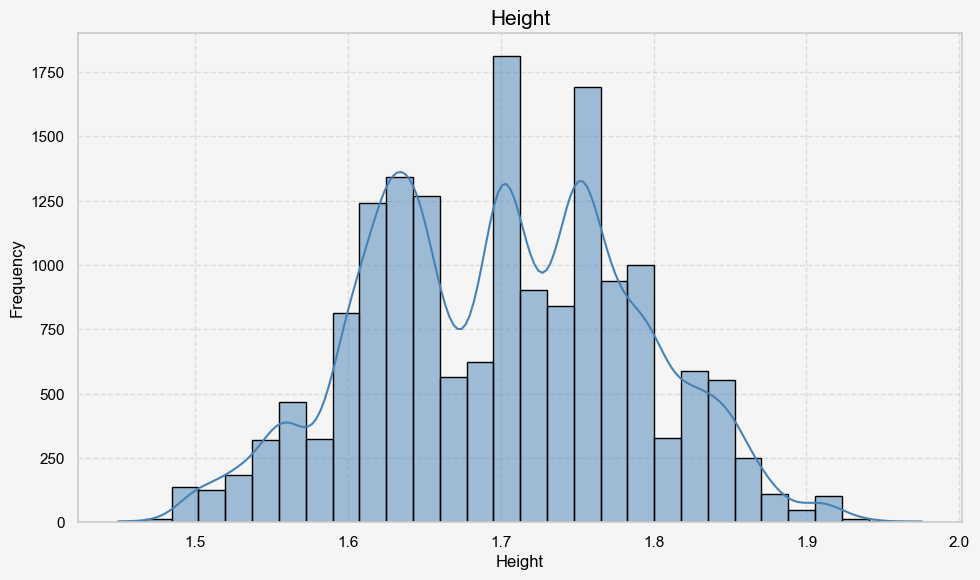

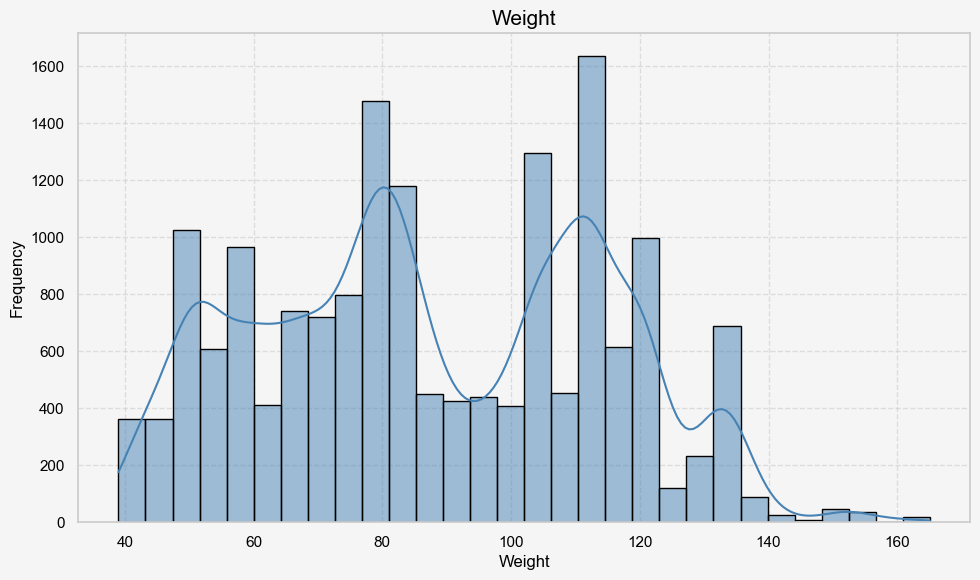

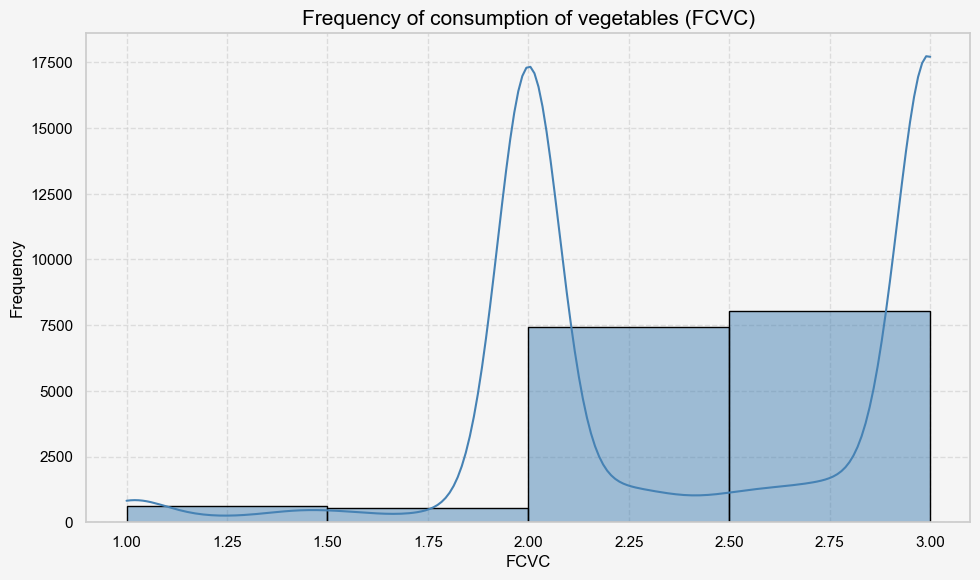

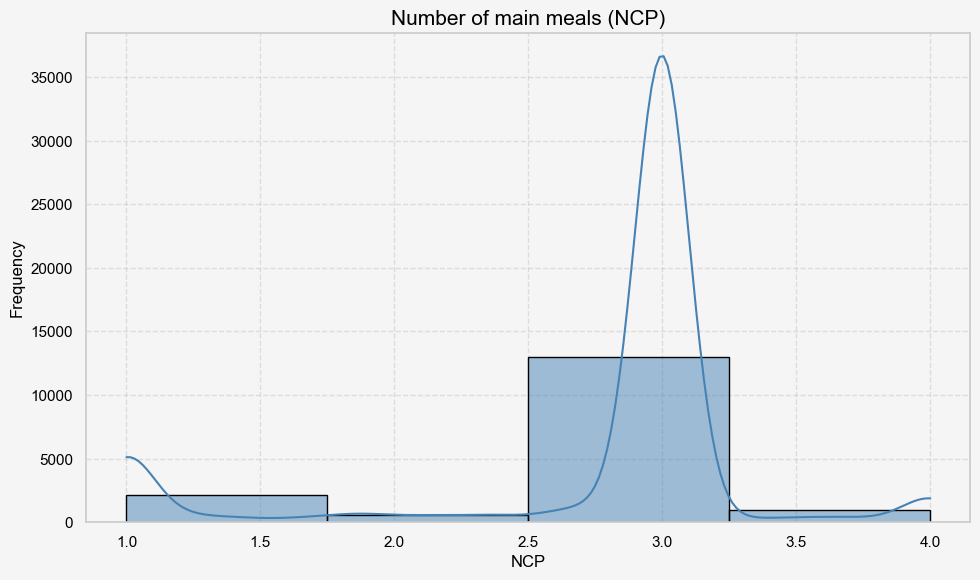

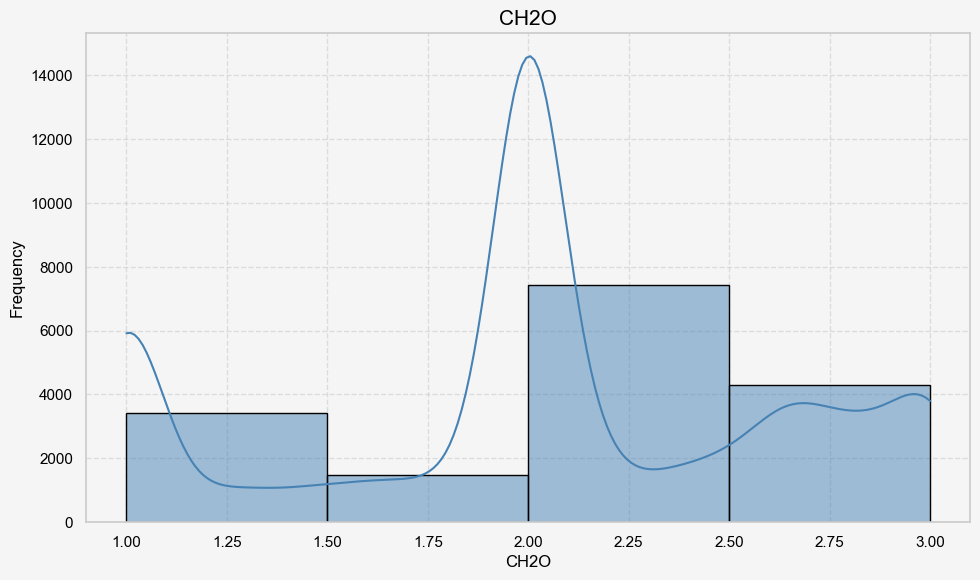

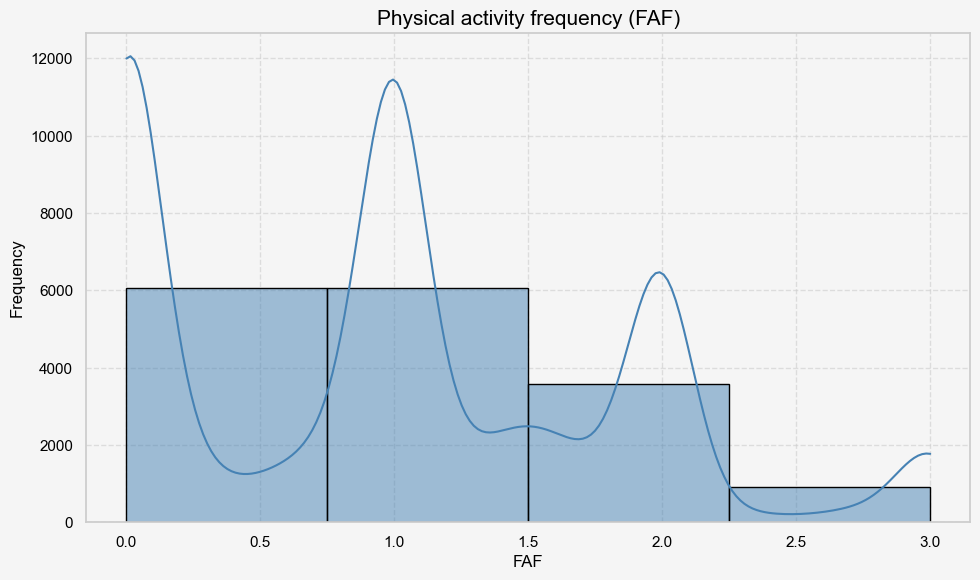

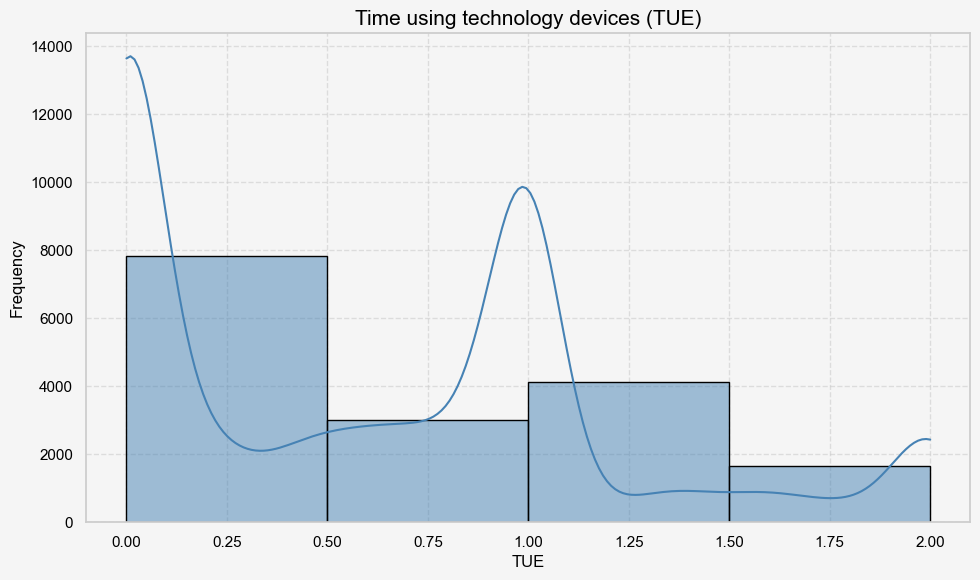

In [102]:
bins = 30

for col in train.columns:
    if train[col].dtype != 'object' and col != 'id':

        plt.figure(figsize=(10, 6))
        ax = plt.gca()

        ax.set_facecolor(background_color)
        plt.gcf().patch.set_facecolor(background_color)

        sns.histplot(train[col], kde=True, bins=bins, color='steelblue', edgecolor='black')

        if col in attribute_meanings:
            title = f"{attribute_meanings[col]} ({col})"
        else:
            title = f"{col}"
        ax.set_title(title, fontsize=15, color='black')

        ax.set_xlabel(col, fontsize=12, color='black')
        ax.set_ylabel("Frequency", fontsize=12, color='black')

        ax.tick_params(colors='black', labelsize=11)

        ax.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.savefig(f"EDA/{col}_distribution_hist.png", dpi=300, facecolor=background_color)
        plt.show()
        if col == 'Weight':
            bins = 4


- **Age Distribution**: The age distribution is **right-skewed**, indicating that the dataset contains **more young individuals** compared to older ones. This could imply a focus on early adulthood or student-age groups.

- **Overall Balance**: Most numerical features appear to be **reasonably well distributed**, with no severe imbalance or extreme skewness (aside from age). This suggests that the dataset is suitable for training machine learning models without extensive resampling.

- **Weight**: The distribution of weight is **multi-modal**, reflecting natural groupings that likely align with the different obesity levels. This supports its usefulness in classifying body weight categories.

- **Height**: Height is approximately **normally distributed**, centered around a typical adult average, which is expected and indicates consistent data quality.

- **Physical Activity (FAF)** and **Technology Use (TUE)**: These features may show skewness or clustering around specific lifestyle patterns, which can be predictive of obesity.

- **Daily Water Intake (CH2O)** and **Vegetable Consumption (FCVC)**: These features may display minor peaks suggesting **certain dominant behavior patterns** (e.g., most people drink 1–2 liters of water or eat veggies with moderate frequency).

<Figure size 1000x800 with 0 Axes>

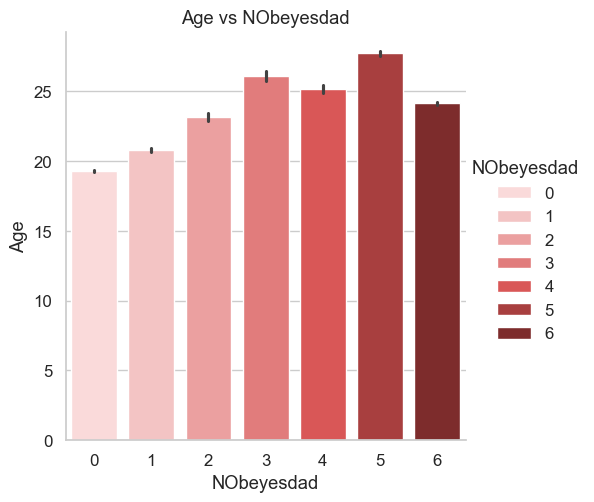

<Figure size 1000x800 with 0 Axes>

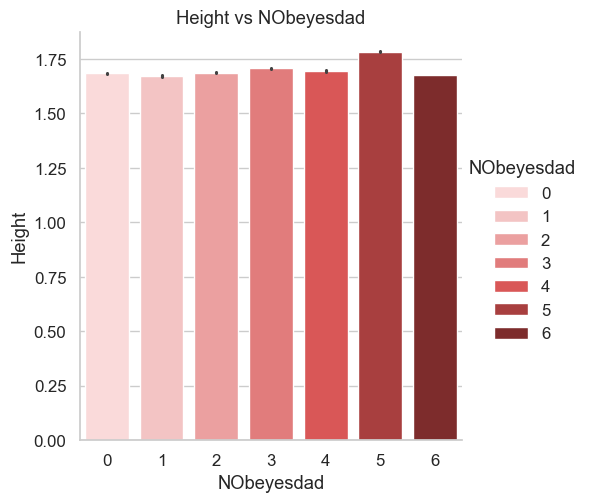

<Figure size 1000x800 with 0 Axes>

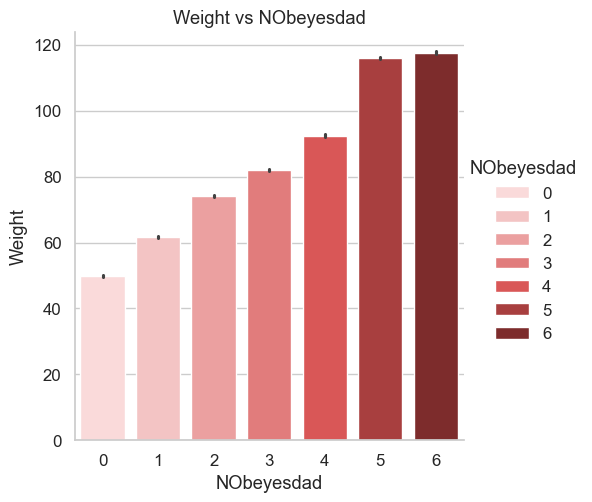

<Figure size 1000x800 with 0 Axes>

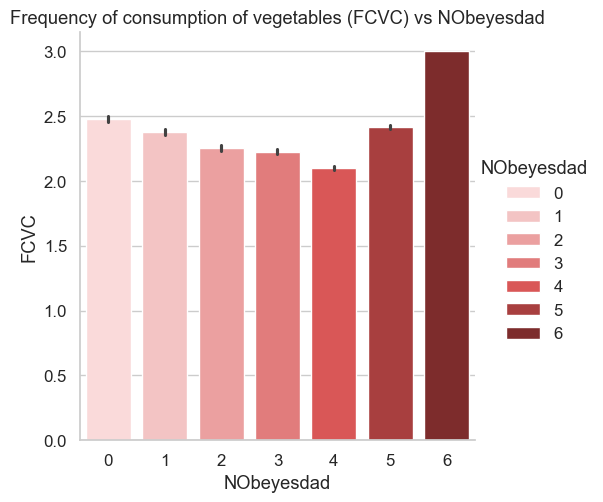

<Figure size 1000x800 with 0 Axes>

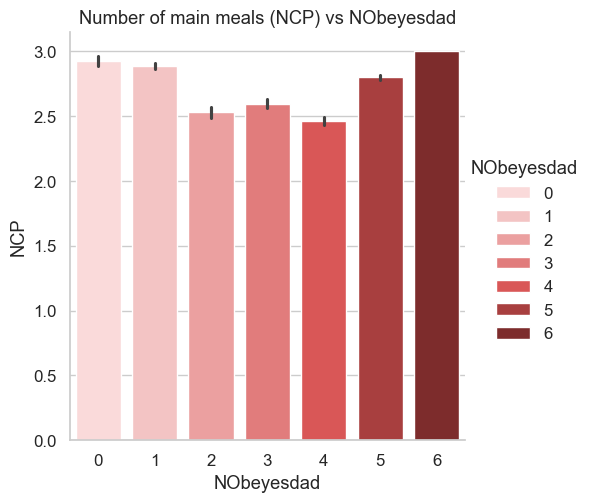

<Figure size 1000x800 with 0 Axes>

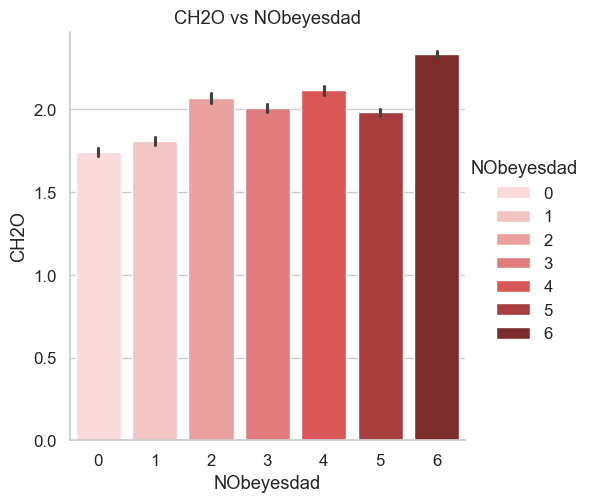

<Figure size 1000x800 with 0 Axes>

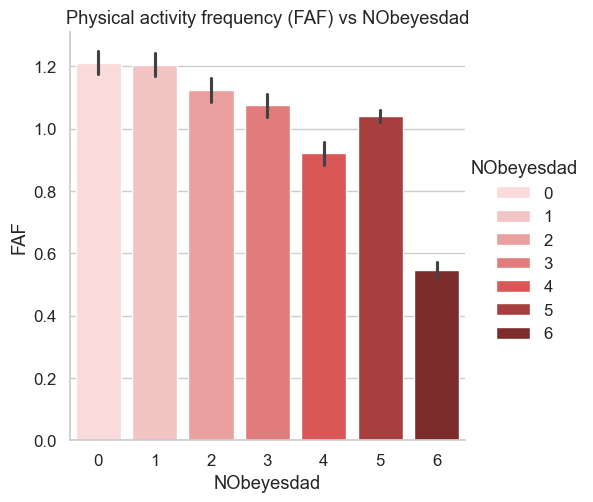

<Figure size 1000x800 with 0 Axes>

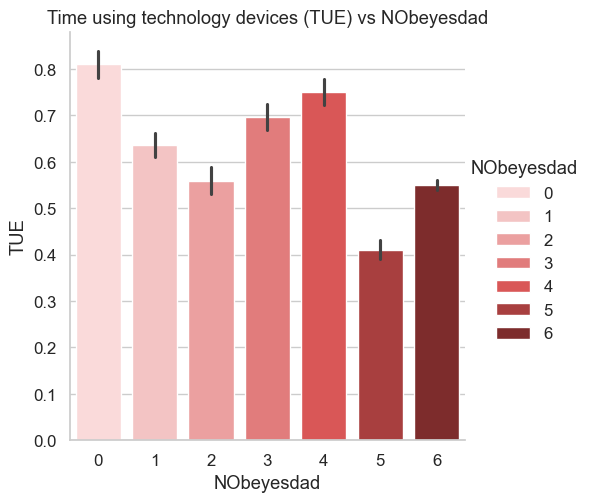

In [103]:
for col in train.columns:
    if train[col].dtype != 'object' and col != 'id':
        plt.figure(figsize=(10, 8))
        sns.catplot(
            data=train,
            kind='bar',
            x=train['NObeyesdad'].map(target_mapping),
            hue=train['NObeyesdad'].map(target_mapping),
            y=col,
            palette=custom_reds
        )
        if col in attribute_meanings:
            plt.title(f"{attribute_meanings[col]} ({col}) vs NObeyesdad")
        else:
            plt.title(f"{col} vs NObeyesdad")
        plt.xlabel('NObeyesdad')
        plt.ylabel(col)
        plt.savefig(f"EDA/{col}_vs_obesity_class.png", dpi=300)
        plt.show()


### **Age vs Obesity Class**
- **Average age increases** steadily from class 0 (Insufficient Weight) to class 5 (Obesity Type II).
- Interestingly, class 6 (Obesity Type III) shows a **drop in average age**, suggesting that some individuals reach severe obesity at younger ages.
- Overall, there's a **positive correlation between age and obesity level** up to a point.

---

### **CH2O (Daily Water Intake) vs Obesity Class**
- Water consumption generally **increases with obesity level**, peaking at class 6.
- This may reflect dietary advice or behavior changes in response to obesity, where individuals with higher weight are trying to hydrate more.
- Alternatively, it might indicate **post-onset adjustments** rather than a cause-effect relationship.

---

### **FAF (Physical Activity Frequency) vs Obesity Class**
- A **clear negative trend**: physical activity **decreases** as obesity level increases.
- Obesity Type III (class 6) shows the **lowest average physical activity**, highlighting the strong inverse relationship between exercise and obesity.
- This could reflect both a contributing factor to obesity and a consequence of reduced mobility.

---

### **FCVC (Frequency of Vegetable Consumption) vs Obesity Class**
- Contrary to expectations, vegetable intake is **highest in class 6 (Obesity Type III)**.
- This might indicate **lifestyle adjustments** after gaining weight (e.g., dieting), rather than original causes.
- Middle classes (3–4) show **slightly lower consumption**, possibly representing a less health-conscious phase.

---

### **Height vs Obesity Class**
- Height remains **mostly consistent** across classes, with minor variations.
- A small peak in class 5 may be incidental.
- No strong correlation between height and obesity level is observed — expected, since height is not behaviorally modifiable.

---

### **NCP (Number of Main Meals per Day) vs Obesity Class**
- Classes 0 and 1 (Insufficient and Normal Weight) have **fewer meals on average**.
- Meal frequency increases in higher obesity classes, especially class 6.
- This suggests a link between **increased meal frequency and higher obesity levels**, though this could also reflect **larger but healthier meals in lower classes**.

---

### **TUE (Time Using Technology Devices) vs Obesity Class**
- Highest tech usage is seen in class 0, and lowest in class 5.
- There’s no consistent monotonic trend, but **sedentary behavior (screen time)** could play a role in moderate weight gain.
- The trend is **non-linear**, hinting at complex lifestyle factors beyond just screen time.

---

### **Weight vs Obesity Class**
- As expected, **weight rises steadily and strongly** across classes.
- The progression is **linear and clean**, validating the correctness of the class labeling.
- This chart reinforces **weight as the most directly correlated feature** with obesity class — as it defines the classes.


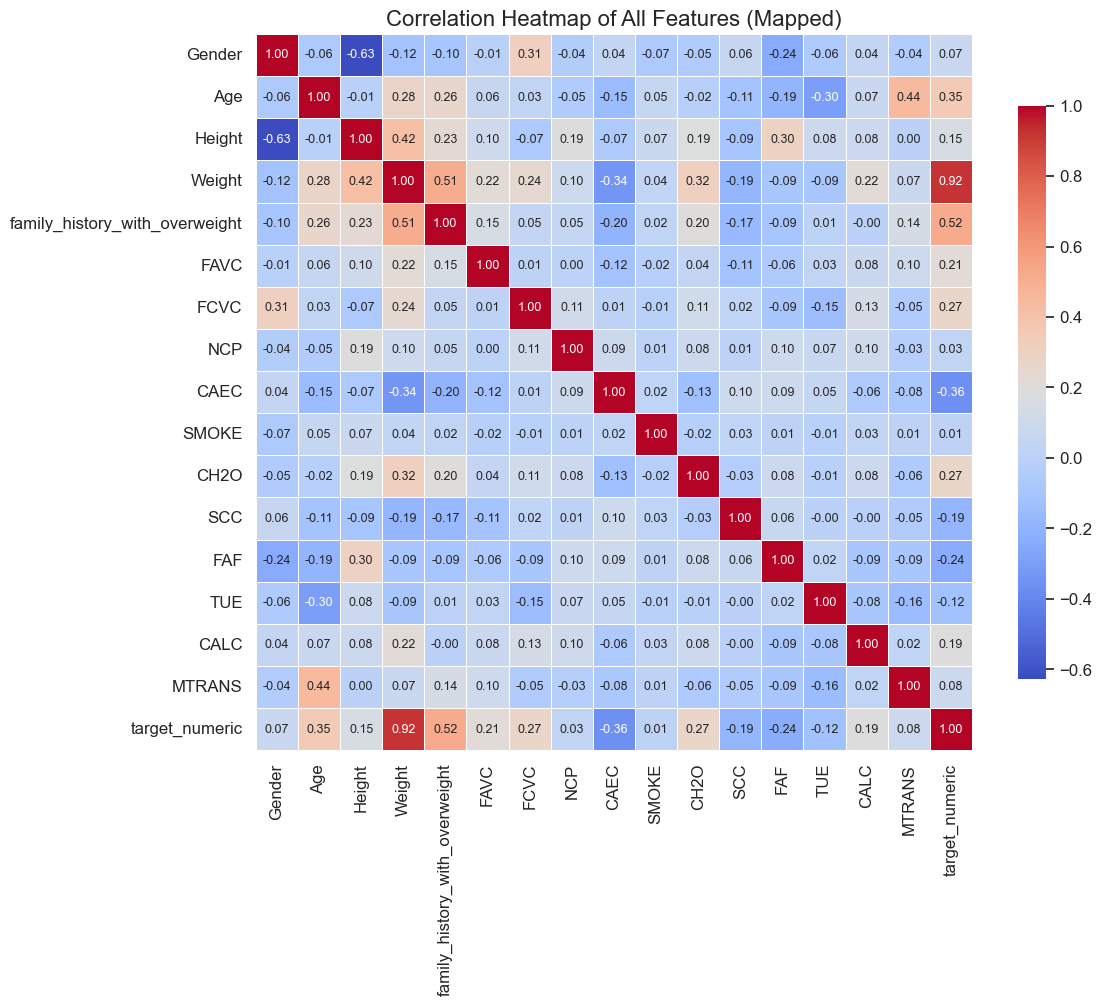

In [106]:
train_corr = train.copy()

if 'id' in train_corr.columns:
    train_corr.drop(columns='id', inplace=True)

for col, mapping in mapping_dict.items():
    if col in train_corr.columns:
        train_corr[col] = train_corr[col].map(mapping)

train_corr.rename(columns={'NObeyesdad': 'target_numeric'}, inplace=True)

corr_matrix = train_corr.corr()

plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)

ax = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 9}
)

plt.title("Correlation Heatmap of All Features (Mapped)", fontsize=16)
plt.tight_layout()
plt.savefig("EDA/correlation_heatmap_mapped.png", dpi=300)
plt.show()


### **Top Correlations with Obesity Class (`target_numeric`)**

- **Weight (0.92)**: As expected, **weight has the strongest positive correlation** with obesity class. It is the defining feature of the class label.
- **Family History with Overweight (0.52)**: Strongly correlated — individuals with a family history of obesity tend to fall in higher obesity classes, supporting the genetic/environmental influence hypothesis.
- **Age (0.35)**: Moderate positive correlation — **older individuals tend to be more obese**, up to a point.
- **CH2O (Water Intake) (0.27)** and **FCVC (Vegetable Consumption) (0.27)**: Interestingly, both show **positive correlation**, likely due to **post-weight gain lifestyle adjustments** rather than causation.
- **FAVC (Frequent high-calorie food consumption) (0.21)** and **CALC (Alcohol Consumption) (0.19)** also correlate positively, aligning with expected behavioral contributions.

---

### **Negative Correlations with Obesity**

- **CAEC (Eating Between Meals) (-0.36)**: Strongest negative correlation — possibly suggesting that skipping snacks or controlled meal timing is linked to lower weight classes.
- **FAF (Physical Activity) (-0.24)**: More physical activity is associated with lower obesity levels, a well-established causal factor.
- **SCC (Calorie Monitoring) (-0.19)**: Suggests people who monitor calories are more likely in lower weight classes.
- **TUE (Technology Use) (-0.12)**: Light negative correlation — sedentary behavior may contribute slightly to weight gain.

---

### **Other Notable Feature Relationships**

- **Weight ↔ Family History (0.51)**: Supports the idea that inherited or shared family environments strongly affect weight.
- **Height ↔ Gender (-0.63)**: Expected, as men are on average taller.
- **Age ↔ Transportation (0.44)**: Possibly indicating **older individuals use cars more** (MTRANS is coded numerically), affecting incidental activity levels.

---

### Final Takeaways

- **Obesity is multifactorial**: While weight dominates as expected, behavioral (FAVC, CH2O, FAF) and family-related factors (history) play significant roles.
- **Lifestyle variables matter**, but their relationships are sometimes indirect — e.g., healthy habits (water/veg) show positive correlation likely due to **post-obesity behavior change**.
- **CAEC and FAF** are two features worth prioritizing in behavioral interventions due to their strong negative correlation.


# `3` Data Preperation

In [13]:
def preprocess(df):
    df = df.copy()
    for col, mapping in mapping_dict.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)
    df = df.drop(columns=['id'])
    return df

In [14]:
X_train = train.drop(columns=['NObeyesdad'])
y_train = train['NObeyesdad'].map(target_mapping)
X_test = test.drop(columns=['NObeyesdad'])
y_test = test['NObeyesdad'].map(target_mapping)

In [15]:
preprocessor = FunctionTransformer(preprocess)
scaler = StandardScaler()

# `4` Random Forest Classifier

## Setting up pipline and random search

In [31]:
model = RandomForestClassifier(random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('model', model)])
params = {
    'model__n_estimators': [100, 500, 1000],
    'model__max_features': [2, 4, 8],
    'model__max_depth': [10, 20, 30, 50],
    'model__max_leaf_nodes': [100, 200, 300],
    'model__min_samples_leaf': [1, 2, 3],
    'model__min_samples_split': [2, 3, 4]
}
RF_random_search = RandomizedSearchCV(pipeline, params, n_iter=50, cv=2, verbose=1, random_state=42, n_jobs=-1)

## Model Training

In [32]:
RF_random_search.fit(X_train, y_train)
best_params = RF_random_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {RF_random_search.best_score_:.4f}")

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters: {'model__n_estimators': 1000, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_leaf_nodes': 300, 'model__max_features': 8, 'model__max_depth': 30}
Best score: 0.8983


## Model Evaluation

In [94]:
y_pred = RF_random_search.predict(X_train)
print(classification_report(y_train, y_pred, target_names=target_mapping.keys()))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.95      0.95      1999
      Normal_Weight       0.90      0.91      0.91      2456
 Overweight_Level_I       0.87      0.82      0.84      1943
Overweight_Level_II       0.86      0.87      0.87      2008
     Obesity_Type_I       0.92      0.92      0.92      2367
    Obesity_Type_II       0.97      0.98      0.98      2591
   Obesity_Type_III       1.00      1.00      1.00      3242

           accuracy                           0.93     16606
          macro avg       0.92      0.92      0.92     16606
       weighted avg       0.93      0.93      0.93     16606



## Generalization Error

In [19]:
y_pred = RF_random_search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_mapping.keys()))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.94       524
      Normal_Weight       0.87      0.88      0.87       626
 Overweight_Level_I       0.77      0.77      0.77       484
Overweight_Level_II       0.80      0.80      0.80       514
     Obesity_Type_I       0.88      0.87      0.88       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



## Feature Importances

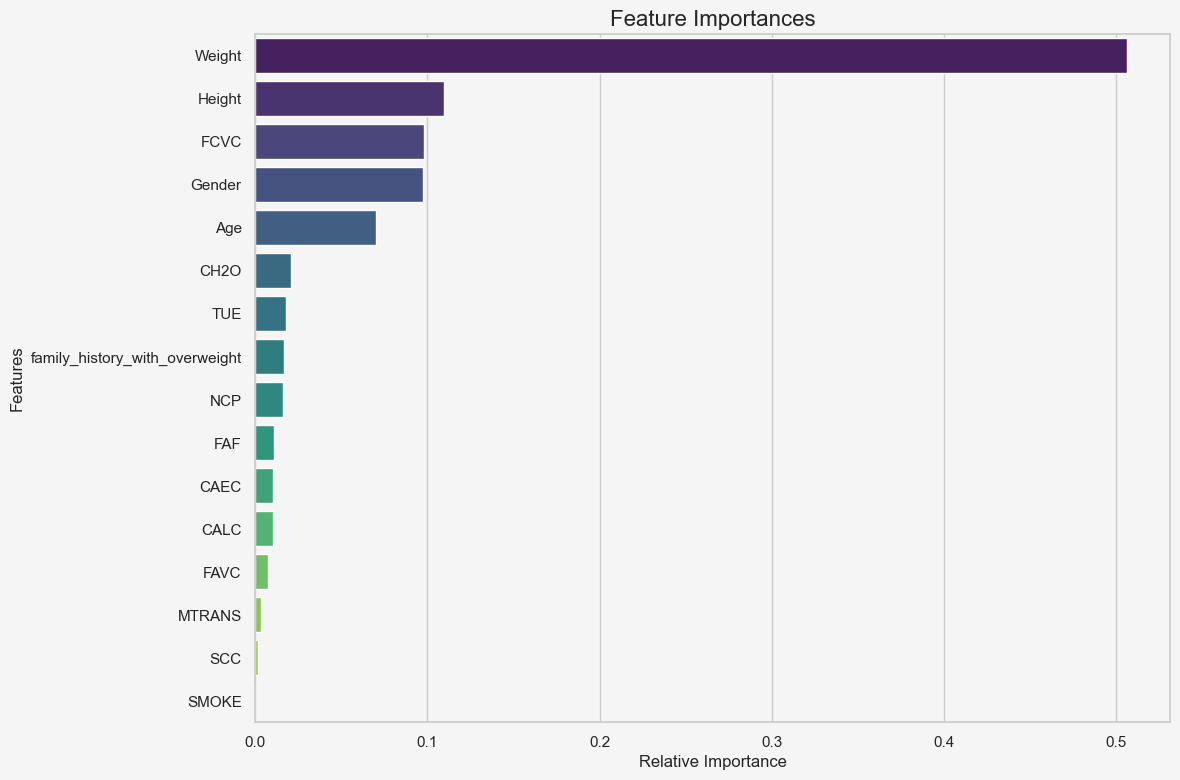

In [105]:
X_feat_plot = X_train.copy()

if 'id' in X_feat_plot.columns:
    X_feat_plot.drop(columns='id', inplace=True)

for col, mapping in mapping_dict.items():
    if col in X_feat_plot.columns:
        X_feat_plot[col] = X_feat_plot[col].map(mapping)

importances = RF_random_search.best_estimator_.named_steps['model'].feature_importances_
feature_names = X_feat_plot.columns
indices = np.argsort(importances)[::-1]

feat_df = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices],
    'Hue': feature_names[indices]
})

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
background_color = '#f5f5f5'
ax = plt.gca()
ax.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

sns.barplot(
    data=feat_df,
    x='Importance',
    y='Feature',
    hue='Hue',
    dodge=False,
    palette='viridis'
)

plt.title("Feature Importances", fontsize=16)
plt.xlabel("Relative Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.savefig("EDA/feature_importance_with_hue.png", dpi=300, facecolor=background_color)
plt.show()


###  **Feature Importance Analysis**

#### Top Predictors:
- **Weight** is by far the most influential feature, contributing nearly **50%** of the predictive power. This is expected since obesity levels are directly tied to body mass.

- **Height**, **FCVC** (vegetable consumption), and **Gender** follow as the next most relevant features.
  - **Height** helps normalize weight into BMI-like patterns.
  - **FCVC** reflects dietary quality.
  - **Gender** introduces biologically relevant variance in weight/fat distribution.

#### Mid-Level Contributors:
- **Age** plays a moderate role, which aligns with your earlier insights that age increases with obesity up to a point.
- **CH2O** (water intake) and **TUE** (technology use) have small but meaningful contributions, likely reflecting lifestyle behaviors.
- **Family history with overweight** adds some predictive signal, but not as much as expected — possibly due to redundancy with actual weight and age.

#### Least Important Features:
- **NCP** (number of meals), **FAF** (physical activity), **CAEC**, **FAVC**, **SCC**, **CALC**, and **SMOKE** have **very minimal influence** on the model’s decision.
  - This may be due to:
    - Low variance in those features,
    - Weak linear relationships,
    - Or the model capturing those effects indirectly through stronger predictors like weight and FCVC.

---

### Interpretation:
- The model relies **heavily on anthropometric data (weight, height)** and **secondarily on lifestyle factors** like diet.
- **Behavioral and transport-related features contribute very little**, suggesting they may only be useful in richer models or multi-modal contexts.

# `5` Gradient Boosting Classifier

## Setting up pipeline and random search

In [20]:
model = GradientBoostingClassifier(random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('model', model)])
params = {
    'model__n_estimators': [100, 500, 1000],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 3, 4],
    'model__min_samples_leaf': [1, 2, 3]
}
GB_random_search = RandomizedSearchCV(pipeline, params, n_iter=50, cv=2, verbose=1, random_state=42, n_jobs=-1)

## Model Training

In [21]:
GB_random_search.fit(X_train, y_train)
best_params = GB_random_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {GB_random_search.best_score_:.4f}")

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 3, 'model__max_depth': 3, 'model__learning_rate': 0.2}
Best score: 0.9012


## Model Evaluation

In [22]:
y_pred = GB_random_search.predict(X_train)
print(classification_report(y_train, y_pred, target_names=target_mapping.keys()))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.96      0.96      1999
      Normal_Weight       0.91      0.92      0.92      2456
 Overweight_Level_I       0.87      0.84      0.85      1943
Overweight_Level_II       0.87      0.88      0.88      2008
     Obesity_Type_I       0.94      0.94      0.94      2367
    Obesity_Type_II       0.99      0.99      0.99      2591
   Obesity_Type_III       1.00      1.00      1.00      3242

           accuracy                           0.94     16606
          macro avg       0.93      0.93      0.93     16606
       weighted avg       0.94      0.94      0.94     16606



## Generalization Error

In [23]:
y_pred = GB_random_search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_mapping.keys()))

                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.94      0.95       524
      Normal_Weight       0.88      0.90      0.89       626
 Overweight_Level_I       0.79      0.80      0.79       484
Overweight_Level_II       0.79      0.78      0.79       514
     Obesity_Type_I       0.87      0.87      0.87       543
    Obesity_Type_II       0.97      0.97      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.90      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.90      0.90      0.90      4152



# `6` LGBM

## Setting up pipline

In [24]:
model = LGBMClassifier(random_state=42)
LGBM_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler), ('model', model)])

## Model training

In [25]:
LGBM_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 16
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574


Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function preprocess at 0x00000215E4E36980>)),
                ('scaler', StandardScaler()),
                ('model', LGBMClassifier(random_state=42))])

## Model Evaluation

In [26]:
y_pred = LGBM_pipeline.predict(X_train)
print(classification_report(y_train, y_pred, target_names=target_mapping.keys()))

                     precision    recall  f1-score   support

Insufficient_Weight       0.99      0.99      0.99      1999
      Normal_Weight       0.97      0.98      0.97      2456
 Overweight_Level_I       0.96      0.94      0.95      1943
Overweight_Level_II       0.96      0.96      0.96      2008
     Obesity_Type_I       0.98      0.99      0.99      2367
    Obesity_Type_II       1.00      1.00      1.00      2591
   Obesity_Type_III       1.00      1.00      1.00      3242

           accuracy                           0.98     16606
          macro avg       0.98      0.98      0.98     16606
       weighted avg       0.98      0.98      0.98     16606



c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Generalization Error

In [27]:
y_pred = LGBM_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_mapping.keys()))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.93      0.94       524
      Normal_Weight       0.88      0.89      0.89       626
 Overweight_Level_I       0.79      0.80      0.79       484
Overweight_Level_II       0.80      0.82      0.81       514
     Obesity_Type_I       0.89      0.87      0.88       543
    Obesity_Type_II       0.97      0.98      0.97       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.91      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.91      0.91      0.91      4152



c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# `7` Applying on testset

In [28]:
y_pred = LGBM_pipeline.predict(testset)
submission = pd.DataFrame({'id': testset['id'], 'NObeyesdad': y_pred})
submission['NObeyesdad'] = submission['NObeyesdad'].map({v: k for k, v in target_mapping.items()})
submission.to_csv('submission.csv', index=False)
submission.head()

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [30]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13840 non-null  int64  
 1   Gender                          13840 non-null  object 
 2   Age                             13840 non-null  float64
 3   Height                          13840 non-null  float64
 4   Weight                          13840 non-null  float64
 5   family_history_with_overweight  13840 non-null  object 
 6   FAVC                            13840 non-null  object 
 7   FCVC                            13840 non-null  float64
 8   NCP                             13840 non-null  float64
 9   CAEC                            13840 non-null  object 
 10  SMOKE                           13840 non-null  object 
 11  CH2O                            13840 non-null  float64
 12  SCC                             